In [1]:
from sklearn.preprocessing import StandardScaler
#from factor_analyzer import FactorAnalyzer, calculate_kmo
from scipy.stats import bartlett
import pandas as pd
from sklearn.preprocessing import StandardScaler
#from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import pingouin as pg
import seaborn as sns

In [2]:
data_path = "data_youtube_cleaned_first_final.csv"
data = pd.read_csv(data_path)
print(data.columns)
data.shape

Index(['video_id', 'video_published_at', 'video_trending__date',
       'video_trending_country', 'channel_id', 'video_title',
       'video_description', 'video_default_thumbnail', 'video_category_id',
       'video_tags', 'video_duration', 'video_dimension', 'video_definition',
       'video_licensed_content', 'video_view_count', 'video_like_count',
       'video_comment_count', 'channel_title', 'channel_description',
       'channel_custom_url', 'channel_published_at', 'channel_country',
       'channel_view_count', 'channel_subscriber_count',
       'channel_have_hidden_subscribers', 'channel_video_count',
       'channel_localized_title', 'channel_localized_description',
       'engagement_rate', 'time_difference', 'video_duration_seconds',
       'time_difference_days', 'channel_cluster',
       'time_to_trend_difference_seconds', 'is_weekend', 'is_trending',
       'published_hour', 'published_morning', 'published_afternoon',
       'published_evening', 'published_night',
      

(28667, 43)

<Axes: xlabel='engagement_rate', ylabel='Count'>

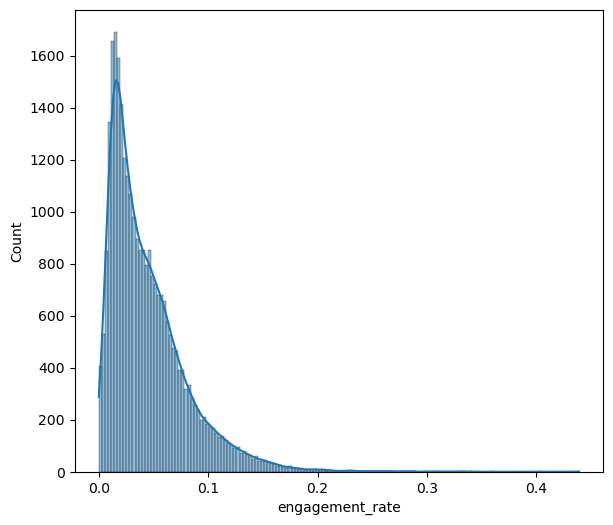

In [4]:
# plot engagement rate
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['engagement_rate'], kde=True)

In [17]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from ultralytics import YOLO  # Use ultralytics YOLO package or adapt for YOLOv5
import os
from icecream import ic 
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import torch
from torchvision import models, transforms
import logging

model = YOLO('yolo11n.pt')
model.overrides['verbose'] = False  # Disable verbose logging
# logging.getLogger("ultralytics").setLevel(logging.ERROR)
thumbnail_urls = data['video_default_thumbnail']
def detect_objects(image):
    results = model(image)  # Perform detection
    detections_df = results[0].to_df()  # Convert detections to a DataFrame
    
    # Check if detections_df is empty
    if detections_df.empty:
        return {'contain_1': None, 'contain_2': None, 'contain_3': None}  # No objects detected

    # Count object occurrences using the 'name' column
    object_counts = detections_df['name'].value_counts()

    # Extract the top 3 detected objects (if available)
    top_objects = object_counts.index.tolist()[:3]
    contains_face = int('person' in top_objects)

    # Map to new keys for clarity
    result = {
        'contain_1': top_objects[0] if len(top_objects) > 0 else None,
        'contain_2': top_objects[1] if len(top_objects) > 1 else None,
        'contain_3': top_objects[2] if len(top_objects) > 2 else None,
    }
    
    return result

def analyze_colors(image):
    image = image.resize((100, 100))  # Resize for speed
    pixels = np.array(image).reshape(-1, 3)  # Flatten pixels
    dominant_color = np.mean(pixels, axis=0)  # Average color (RGB)
    brightness = np.mean(np.sqrt(np.sum(pixels**2, axis=1)))  # Brightness metric
    color_diversity = len(np.unique(pixels, axis=0))  # Distinct colors
    return {
        'dominant_color_r': dominant_color[0],
        'dominant_color_g': dominant_color[1],
        'dominant_color_b': dominant_color[2],
        'brightness': brightness,
        'color_diversity': color_diversity
    }

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 34.9MB/s]


In [ ]:
results_list = []
for url in tqdm(thumbnail_urls, desc="Processing Thumbnails", unit="image"):
    try:
        # Download image
        response = requests.get(url, timeout=5)
        image = Image.open(BytesIO(response.content)).convert("RGB")

        # Detect objects
        detection_results = detect_objects(image)
        color_analysis = analyze_colors(image)
        combined_results = {**detection_results, **color_analysis, 'thumbnail_url': url}
        results_list.append(combined_results)
    
    except Exception as e:
        print(f"Failed to process {url}: {e}")
        results_list.append({'thumbnail_url': url, 'error': str(e)})

final_data = pd.merge(data, pd.DataFrame(results_list), how="left", left_on='video_default_thumbnail', right_on='thumbnail_url')

Processing Thumbnails:  48%|████▊     | 11448/23933 [41:03<38:23,  5.42image/s]  

In [5]:
final_data.columns

Index(['video_id', 'video_published_at', 'video_trending__date',
       'video_trending_country', 'channel_id', 'video_title',
       'video_description', 'video_default_thumbnail', 'video_category_id',
       'video_tags', 'video_duration', 'video_dimension', 'video_definition',
       'video_licensed_content', 'video_view_count', 'video_like_count',
       'video_comment_count', 'channel_title', 'channel_description',
       'channel_custom_url', 'channel_published_at', 'channel_country',
       'channel_view_count', 'channel_subscriber_count',
       'channel_have_hidden_subscribers', 'channel_video_count',
       'channel_localized_title', 'channel_localized_description',
       'engagement_rate', 'time_difference', 'video_duration_seconds',
       'time_difference_days', 'channel_cluster',
       'time_to_trend_difference_seconds', 'is_weekend', 'is_trending',
       'published_hour', 'published_morning', 'published_afternoon',
       'published_evening', 'published_night',
      

In [6]:
final_data.time_to_trend_difference_seconds

0         86394.0
1        374390.0
2        261583.0
3        390372.0
4        316800.0
           ...   
28662     53993.0
28663    138586.0
28664     25145.0
28665    115152.0
28666    113395.0
Name: time_to_trend_difference_seconds, Length: 28667, dtype: float64

In [7]:
data = final_data.copy()
data.shape

(28667, 52)

In [8]:
text_features = ['video_title']

def clean_text_column(column):
    """Clean a text column by filling nulls and removing special characters."""
    return (
        column.fillna("")  # Fill missing values with empty string
        .str.replace(r"[^\w\s]", " ", regex=True)  # Remove special characters
        .str.lower()  # Convert to lowercase
        .str.strip()  # Remove leading/trailing spaces
    )

for text_feature in text_features:
    data[text_feature] = clean_text_column(data[text_feature])

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('Snowflake/snowflake-arctic-embed-l-v2.0', trust_remote_code=True)
sentence_embeddings = {}
for text_feature in text_features:
    text_data = data[text_feature].tolist()
    embeddings = model.encode(text_data, show_progress_bar=True)
    sentence_embeddings[text_feature] = pd.DataFrame(
        embeddings, 
        columns=[f"{text_feature}_dim{i}" for i in range(embeddings.shape[1])]
    )

embedded_text = pd.concat(sentence_embeddings.values(), axis=1)

/workspace/testa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 896/896 [01:16<00:00, 11.76it/s]


In [9]:
embedded_text

,video_title_dim0,video_title_dim1,video_title_dim2,video_title_dim3,video_title_dim4,video_title_dim5,video_title_dim6,video_title_dim7,video_title_dim8,video_title_dim9,...,video_title_dim1014,video_title_dim1015,video_title_dim1016,video_title_dim1017,video_title_dim1018,video_title_dim1019,video_title_dim1020,video_title_dim1021,video_title_dim1022,video_title_dim1023
0,-0.029332,0.073457,-0.025387,0.051385,-0.080761,0.003588,-0.029849,-0.018211,-0.117816,0.009209,...,0.015424,-0.010135,0.046761,-0.029204,-0.006269,-0.005549,0.026758,-0.023919,-0.016431,-0.009516
1,-0.013054,-0.000616,0.072254,-0.051791,0.044645,0.001377,0.039985,0.047299,-0.014075,0.021160,...,0.002187,-0.035403,-0.013216,0.013668,-0.034749,-0.000036,-0.061827,-0.003422,-0.017927,-0.012627
2,0.042582,0.016391,-0.015819,-0.063033,0.009769,0.021309,0.083345,-0.019655,0.007981,-0.027883,...,-0.018262,-0.018402,0.019069,-0.003547,0.011398,-0.040206,0.008057,-0.013344,0.000106,-0.030069
3,0.033424,0.041401,-0.009190,0.019307,-0.004661,0.037436,-0.056490,-0.106802,0.004678,-0.006344,...,0.010953,-0.014173,0.018121,-0.033014,0.003271,-0.003408,-0.015149,0.003807,-0.011146,0.009140
4,-0.050275,0.061590,-0.008719,-0.019276,-0.041856,-0.021160,0.046297,-0.004198,-0.009820,-0.062832,...,-0.035913,-0.017375,-0.035710,0.028675,0.005439,0.019691,-0.019989,-0.013979,0.037143,-0.067860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28662,-0.013107,0.033865,0.043237,0.060632,-0.046354,0.058876,0.060552,-0.018497,-0.027168,-0.044060,...,0.003851,-0.030513,0.074600,0.004872,-0.022599,-0.006109,0.001768,0.001998,0.011617,0.008535
28663,0.010467,0.009731,0.003371,0.013284,-0.079033,0.058272,-0.022454,-0.014205,-0.009706,-0.079112,...,0.009782,0.012875,0.007456,-0.013360,0.011372,-0.021392,-0.018166,0.005227,-0.002470,-0.011648
28664,0.004375,0.029462,-0.021653,0.002965,-0.045587,0.035810,0.025396,-0.015869,-0.035586,-0.067375,...,0.013877,0.012548,0.050731,-0.023280,-0.039941,-0.004542,-0.018185,-0.007802,0.028199,-0.032188
28665,-0.007436,0.071950,-0.068971,-0.018144,0.038449,0.052377,0.011597,0.010817,0.022876,-0.021684,...,-0.002786,-0.015963,0.059142,-0.020516,0.007483,-0.000725,-0.033344,-0.002203,0.007554,-0.007965


In [10]:
data['tag_count'] = data['video_tags'].apply(lambda x: 0 if x == 'No tags' else len(x.split(',')))
data['tag_count'].value_counts()

tag_count
0      7748
6       669
4       663
23      657
14      652
       ... 
99        1
111       1
94        1
93        1
131       1
Name: count, Length: 110, dtype: int64

In [11]:
from sklearn.decomposition import PCA
embedding_dim = 4
pca = PCA(n_components=embedding_dim)
reduced_embeddings = pca.fit_transform(np.array(embedded_text))

embedding_columns = [f"text_embeddings_{i}" for i in range(embedding_dim)]
embedding_df = pd.DataFrame(reduced_embeddings, columns=embedding_columns)
embedding_df.shape

(28667, 4)

In [12]:
data = pd.concat([data, embedding_df], axis=1)
data.shape

(28667, 57)

In [13]:
categorical_features = [
    'video_category_id', 'is_weekend',
    'video_definition', 'video_dimension', 'video_licensed_content',
    'channel_have_hidden_subscribers',
    'published_morning', 'published_afternoon', 'published_evening', 'published_night', 'contain_1', 'contain_2',
       'contain_3'
]
numerical_features = [
    'video_duration_seconds', 'channel_video_count', 'channel_video_channel_publish_difference',
    'dominant_color_r', 'dominant_color_g', 'dominant_color_b',
       'brightness', 'color_diversity','tag_count'
]
embedded_text_columns = embedding_df.columns.tolist()
embedded_text_columns

['text_embeddings_0',
 'text_embeddings_1',
 'text_embeddings_2',
 'text_embeddings_3']

In [14]:
final_data.channel_video_count

0           43
1         5274
2        36548
3          920
4          952
         ...  
28662      318
28663     3383
28664       72
28665       21
28666       28
Name: channel_video_count, Length: 28667, dtype: int64

In [15]:
X_categorical = data[categorical_features]
X_numerical = data[numerical_features]
X_text = data[embedded_text_columns]
y = data['engagement_rate']

In [16]:
# from sklearn.ensemble import IsolationForest
# isolation_forest = IsolationForest(contamination=0.10, random_state=42) 
# outliers = isolation_forest.fit_predict(X_numerical)

# data_cleaned = data[outliers != -1]
# data_cleaned.shape

In [17]:
import numpy as np
X = pd.concat((X_numerical, X_categorical, X_text),axis=1)
X.shape

(28667, 26)

In [18]:
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, DropCorrelatedFeatures
from feature_engine.pipeline import Pipeline
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import RareLabelEncoder
pipeline = Pipeline([
    ("categorical_imputer", CategoricalImputer(
    variables=['contain_1', 'contain_2', 'contain_3'],
    fill_value="Empty")),
    ("rare_label_encode", RareLabelEncoder(tol=0.005, ignore_format=False)),
    ("num_rare_label_encode", RareLabelEncoder(tol=0.005, ignore_format=True, variables=['tag_count'], replace_with=-1)),
    ("drop_constant_features", DropConstantFeatures(tol=0.90)),
    ("drop_duplicate_features", DropDuplicateFeatures()),
    ("drop_correlated_features", DropCorrelatedFeatures(method='pearson', threshold=0.90))
])

X_final = pipeline.fit_transform(X)
X_final.shape

/workspace/testa/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable video_definition is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/workspace/testa/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable video_dimension is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(


(28667, 22)

In [19]:
# check difference of columns between X and X_final
set(X.columns) - set(X_final.columns)

{'channel_have_hidden_subscribers',
 'video_definition',
 'video_dimension',
 'video_licensed_content'}

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=0)

In [21]:
categorical_features = [
    'video_category_id', 'is_weekend', 
    'published_morning', 'published_afternoon', 'published_evening', 'published_night', 'contain_1', 'contain_2','contain_3'
]
numerical_features = [
    'video_duration_seconds', 'channel_video_count', 'channel_video_channel_publish_difference',
    'dominant_color_r', 'dominant_color_b', 'dominant_color_g',
       'brightness', 'color_diversity','tag_count'
]

In [22]:
X_train_categorical = X_train[categorical_features]
X_test_categorical = X_test[categorical_features]

X_train_numerical = X_train[numerical_features]
X_test_numerical = X_test[numerical_features]

X_train_text = X_train[embedded_text_columns]
X_test_text = X_test[embedded_text_columns]

In [23]:
from feature_engine.encoding import DecisionTreeEncoder
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import MeanEncoder

encoder = DecisionTreeEncoder(random_state=42, regression=True)
X_train_encode = encoder.fit_transform(X_train_categorical, y_train)
X_test_encode = encoder.transform(X_test_categorical)

In [24]:
# from feature_engine.transformation import LogTransformer

# log_transformer = LogTransformer(variables=numerical_features)

# X_train_log = log_transformer.fit_transform(X_train_numerical)
# X_test_log = log_transformer.transform(X_test_numerical) # di naman gumana hahahaha

In [25]:
# from imblearn.combine import SMOTEENN
# smote_enn = SMOTEENN(random_state=42)
# X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_combined, X_test_combined)

In [26]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_numerical)
# X_test_scaled = scaler.transform(X_test_numerical)
# # X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_scaled, y_train)
# X_train = np.hstack((X_train_encode, X_train_scaled))
# X_test = np.hstack((X_test_encode, X_test_scaled))

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import MinMaxScaler
mmx_scaler = MinMaxScaler()
X_train_mmx = mmx_scaler.fit_transform(np.hstack((X_train_numerical, X_train_encode, X_train_text)))
X_test_mmx = mmx_scaler.transform(np.hstack((X_test_numerical, X_test_encode, X_test_text)))

regressor = RandomForestRegressor(random_state=42)

regressor.fit(X_train_mmx, y_train)

y_pred_train = regressor.predict(X_train_mmx)
y_pred_test = regressor.predict(X_test_mmx)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Train R2: {train_r2}")
print(f"Test R2: {test_r2}")

Train MSE: 0.00011699552434722811
Test MSE: 0.0008719827579922233
Train R2: 0.9091654875538617
Test R2: 0.35091334593651347


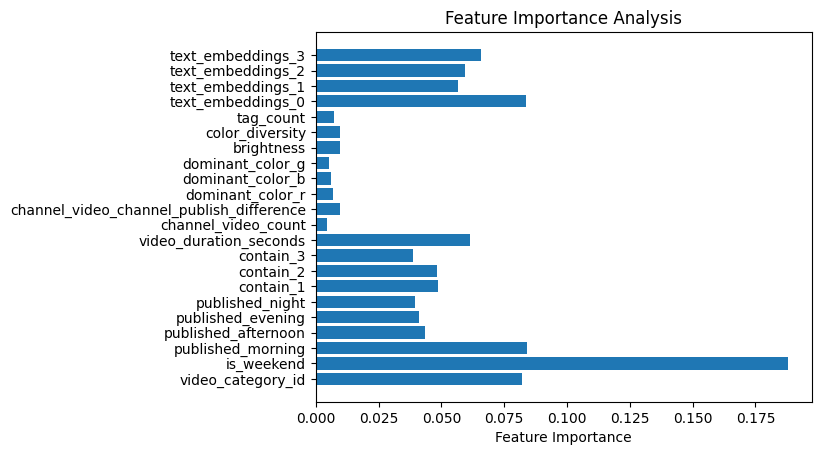

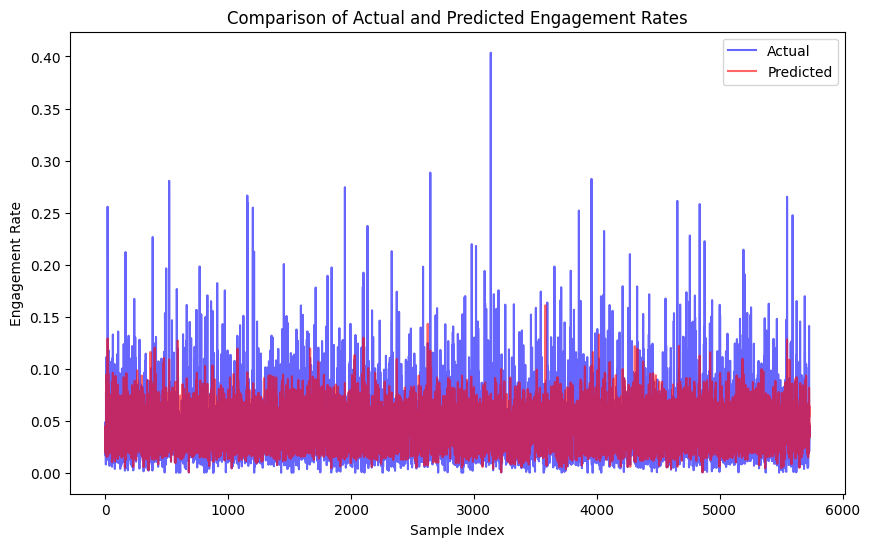

In [32]:
import matplotlib.pyplot as plt
feature_importances = regressor.feature_importances_
feature_names = list(X_train_categorical.columns) + list(X_train_numerical.columns) + list(X_train_text.columns)
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Analysis')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', color='blue', alpha=0.6)
plt.plot(y_pred_test, label='Predicted', color='red', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('Engagement Rate')
plt.title('Comparison of Actual and Predicted Engagement Rates')
plt.legend()
plt.show()

In [39]:
import shap
shap.initjs()
import matplotlib.pyplot as plt
explainer = shap.TreeExplainer(regressor)
scaled_data_frame = pd.DataFrame(X_test_mmx, columns=X_test.columns)
sample_index = 0
X_sample = scaled_data_frame[88:89]
shap_values = explainer.shap_values(X_sample)
expected_value = explainer.expected_value
shap.force_plot(expected_value, shap_values, X_sample, matplotlib=False)

In [42]:
import shap
shap.initjs()
import matplotlib.pyplot as plt
explainer = shap.TreeExplainer(regressor)
scaled_data_frame = pd.DataFrame(X_test_mmx, columns=X_test.columns)
sample_index = 0
X_sample = scaled_data_frame[54:55]
shap_values = explainer.shap_values(X_sample)
expected_value = explainer.expected_value
shap.force_plot(expected_value, shap_values, X_sample, matplotlib=False)

In [43]:
import shap
shap.initjs()
import matplotlib.pyplot as plt
explainer = shap.TreeExplainer(regressor)
scaled_data_frame = pd.DataFrame(X_test_mmx, columns=X_test.columns)
sample_index = 0
X_sample = scaled_data_frame[123:124]
shap_values = explainer.shap_values(X_sample)
expected_value = explainer.expected_value
shap.force_plot(expected_value, shap_values, X_sample, matplotlib=False)

In [61]:
y_test.max()

np.float64(0.4036229360380518)

In [55]:
scaled_data_frame

,video_duration_seconds,channel_video_count,channel_video_channel_publish_difference,dominant_color_r,dominant_color_g,dominant_color_b,brightness,color_diversity,tag_count,video_category_id,...,published_afternoon,published_evening,published_night,contain_1,contain_2,contain_3,text_embeddings_0,text_embeddings_1,text_embeddings_2,text_embeddings_3
0,0.004290,0.004561,0.34580,0.427534,0.519219,0.541652,0.686850,0.781221,0.268293,0.100285,...,0.0,1.0,0.0,0.635304,0.528699,0.579266,0.403276,0.886523,0.672209,0.763532
1,0.027395,0.008513,0.26975,0.190286,0.083703,0.136017,0.649800,0.504183,0.512195,0.874016,...,1.0,0.0,0.0,1.000000,1.000000,1.000000,0.313130,0.583225,0.284894,0.111627
2,0.001119,0.000984,0.04260,0.392189,0.427391,0.387426,0.815842,0.653342,0.024390,0.429270,...,0.0,0.0,0.0,0.635304,0.528699,1.000000,0.400439,0.354771,0.502978,0.549525
3,0.000699,0.156939,0.32470,0.278326,0.458199,0.329431,0.708148,0.668836,0.414634,0.429270,...,1.0,0.0,0.0,0.635304,1.000000,1.000000,0.183324,0.454117,0.223538,0.171514
4,0.000210,0.003952,0.03885,0.451646,0.387625,0.358013,0.914691,0.591984,0.024390,0.486240,...,1.0,0.0,0.0,0.635304,1.000000,1.000000,0.684762,0.378661,0.459629,0.612170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5729,0.013593,0.001127,0.23170,0.589503,0.530100,0.528178,0.648746,0.699308,0.024390,0.874016,...,1.0,0.0,0.0,0.843801,1.000000,1.000000,0.573999,0.251620,0.440284,0.639236
5730,0.041967,0.003819,0.16940,0.266109,0.254319,0.257755,0.673642,0.751265,0.414634,0.874016,...,1.0,1.0,0.0,0.843801,1.000000,1.000000,0.583710,0.613064,0.419240,0.447699
5731,0.228183,0.005230,0.10375,0.238883,0.402686,0.296873,0.649695,0.750439,0.731707,0.100285,...,0.0,1.0,0.0,0.635304,0.528699,1.000000,0.147774,0.711277,0.469403,0.495806
5732,0.015248,0.000585,0.11085,0.251256,0.178671,0.193183,0.664314,0.691044,0.024390,0.486240,...,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.638073,0.491382,0.368374,0.640617


In [58]:
scaled_data_frame[3137:3138]

,video_duration_seconds,channel_video_count,channel_video_channel_publish_difference,dominant_color_r,dominant_color_g,dominant_color_b,brightness,color_diversity,tag_count,video_category_id,...,published_afternoon,published_evening,published_night,contain_1,contain_2,contain_3,text_embeddings_0,text_embeddings_1,text_embeddings_2,text_embeddings_3
3137,0.00049,0.003976,0.29925,0.468028,0.445148,0.455674,0.667844,0.673071,0.121951,1.0,...,1.0,0.0,0.0,0.635304,1.0,1.0,0.410312,0.306055,0.654935,0.377366


In [26]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# Define a dictionary of models to evaluate
models = {
    "Polynomial Regression (Degree 2)": Pipeline([
        ('scaler', MinMaxScaler()),
        ('poly_features', PolynomialFeatures(degree=2)),
        ('regressor', LinearRegression())
    ]),
    "Random Forest": Pipeline([
        ('scaler', MinMaxScaler()),
        ('regressor', RandomForestRegressor(random_state=42))
    ]),
    "XGBoost": Pipeline([
        ('scaler', MinMaxScaler()),
        ('regressor', XGBRegressor(random_state=42))
    ])
}

# Define custom scorer for mean squared error and R2
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Iterate through models and evaluate using cross-validation
results = []
for model_name, model_pipeline in models.items():
    print(f"Evaluating {model_name}...")
    mse_scores = cross_val_score(model_pipeline, np.hstack((X_train_numerical, X_train_encode, X_train_text)), y_train,
                                 cv=5, scoring=mse_scorer)
    r2_scores = cross_val_score(model_pipeline, np.hstack((X_train_numerical, X_train_encode, X_train_text)), y_train,
                                cv=5, scoring=r2_scorer)
    results.append({
        "Model": model_name,
        "Mean MSE": -np.mean(mse_scores),
        "Mean R2": np.mean(r2_scores),
        "Std MSE": np.std(mse_scores),
        "Std R2": np.std(r2_scores)
    })

# Display the results
import pandas as pd
results_df = pd.DataFrame(results)

# # Plot the feature importances for Random Forest (if applicable)
# if "Random Forest" in models:
#     rf_model = models["Random Forest"]
#     rf_model.fit(np.hstack((X_train_numerical, X_train_encode, X_train_text)), y_train)
#     feature_importances = rf_model.named_steps['regressor'].feature_importances_
#     feature_names = list(X_train_categorical.columns) + list(X_train_numerical.columns)
#     plt.figure(figsize=(8, 6))
#     plt.barh(feature_names, feature_importances)
#     plt.xlabel('Feature Importance')
#     plt.title('Random Forest Feature Importance Analysis')
#     plt.show()
results_df

Evaluating Polynomial Regression (Degree 2)...
Evaluating Random Forest...
Evaluating XGBoost...


,Model,Mean MSE,Mean R2,Std MSE,Std R2
0,Polynomial Regression (Degree 2),0.000940,0.269874,0.000064,0.013959
1,Random Forest,0.000838,0.349062,0.000051,0.016252
2,XGBoost,0.000887,0.310507,0.000057,0.016580
